# Main

In [1]:
from ColorMap import *
from tqdm import tqdm 
import pandas as pd
import cv2
import csv
from PSO import *
import os
import copy

In [2]:
# csvの書き出し
def export_csv(filename, data):
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)

In [3]:
color_map =  ColorMap(griewank_function, [-6, 6], [-6, 6] ,400, 400)
color_map.generate_coordinate()

In [4]:
def init_learning(N, omega, c1, c2, D, up_lim, lo_lim, func):
    pso = PSO(N, omega, c1, c2, D, up_lim, lo_lim, func)
    pso.init_phase()
    return pso

def execute_learning(pso, G, filename_prefix):
    os.makedirs('output/%s/images' % filename_prefix, exist_ok=True)
    
    evaluations_data = []
    label = ["pb%d_ev" % i for i in range(N)]
    label.append("gb_ev")
    evaluations_data.append(label)
    
    for g in tqdm(range(G)):
        pso.solution_search_phase()
        color_map.draw_map()
        pd_xs = pd.DataFrame(pso.xs)
        pd_pb = pd.DataFrame(pso.pb)
        evs = copy.copy(pso.pb_evaluations)
        evs.append(pso.func(*pso.gb))
        evaluations_data.append(evs)
        
        color_map.draw_points(pd_xs[0], pd_xs[1], 'grey')   
        color_map.draw_points(pd_pb[0], pd_pb[1], 'white')
        color_map.draw_points([pso.gb[0]], [pso.gb[1]], 'gold')
        plt.savefig('output/%s/images/img_%04d.png' % (filename_prefix, g))
        
    #結果出力(csv)
    export_csv('csv/%s_best_eval.csv' % filename_prefix, evaluations_data)
    
    #結果出力(動画)
    # encoder(for mp4)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    # output file name, encoder, fps, size(fit to image size)
    video = cv2.VideoWriter('video/%s_video.mp4' % filename_prefix, fourcc, 20.0, (432, 288))
    if not video.isOpened():
        print("can't be opened")
        exit()

    for i in tqdm(range(0, G)):
        # hoge0000.png, hoge0001.png,..., hoge0090.png
        img = cv2.imread('output/%s/images/img_%04d.png' % (filename_prefix, i))

        # can't read image, escape
        if img is None:
            print("can't read")
            break

        # add
        video.write(img)
    #     print("read image " + str(i))

    video.release()
    print('written')

100%|██████████| 50/50 [00:00<00:00, 282.19it/s]


written


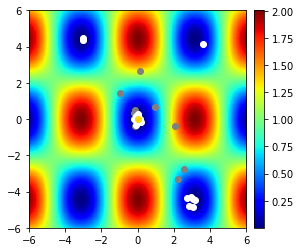

In [5]:
N = 20
G = 30
omega = 0.8
c1 = 2.6
c2 = 1.0
D = 2
up_lim = 5.0
lo_lim = -5.0
func = griewank_function
parameters = [
    {'N' : 20, 'G' : 50, 'omega' : 0.8, 'c1' : 2.6, 'c2' : 1.0, 'D' : 2, 'up_lim' : 5.0, 'lo_lim' : -5.0, 'func' : griewank_function, 'filename_prefix' : ''}
]


for p in parameters:
    p['filename_prefix'] = 'N%dG%d_o%s_cp%s_cg%s' % (p['N'], p['G'], str(p['omega']).replace('.', 'd'), str(p['c1']).replace('.', 'd'), str(p['c2']).replace('.', 'd'))
    pso = init_learning(p['N'],  p['omega'], p['c1'], p['c2'], p['D'], p['up_lim'], p['lo_lim'], p['func'])
    execute_learning(pso, p['G'], p['filename_prefix'])